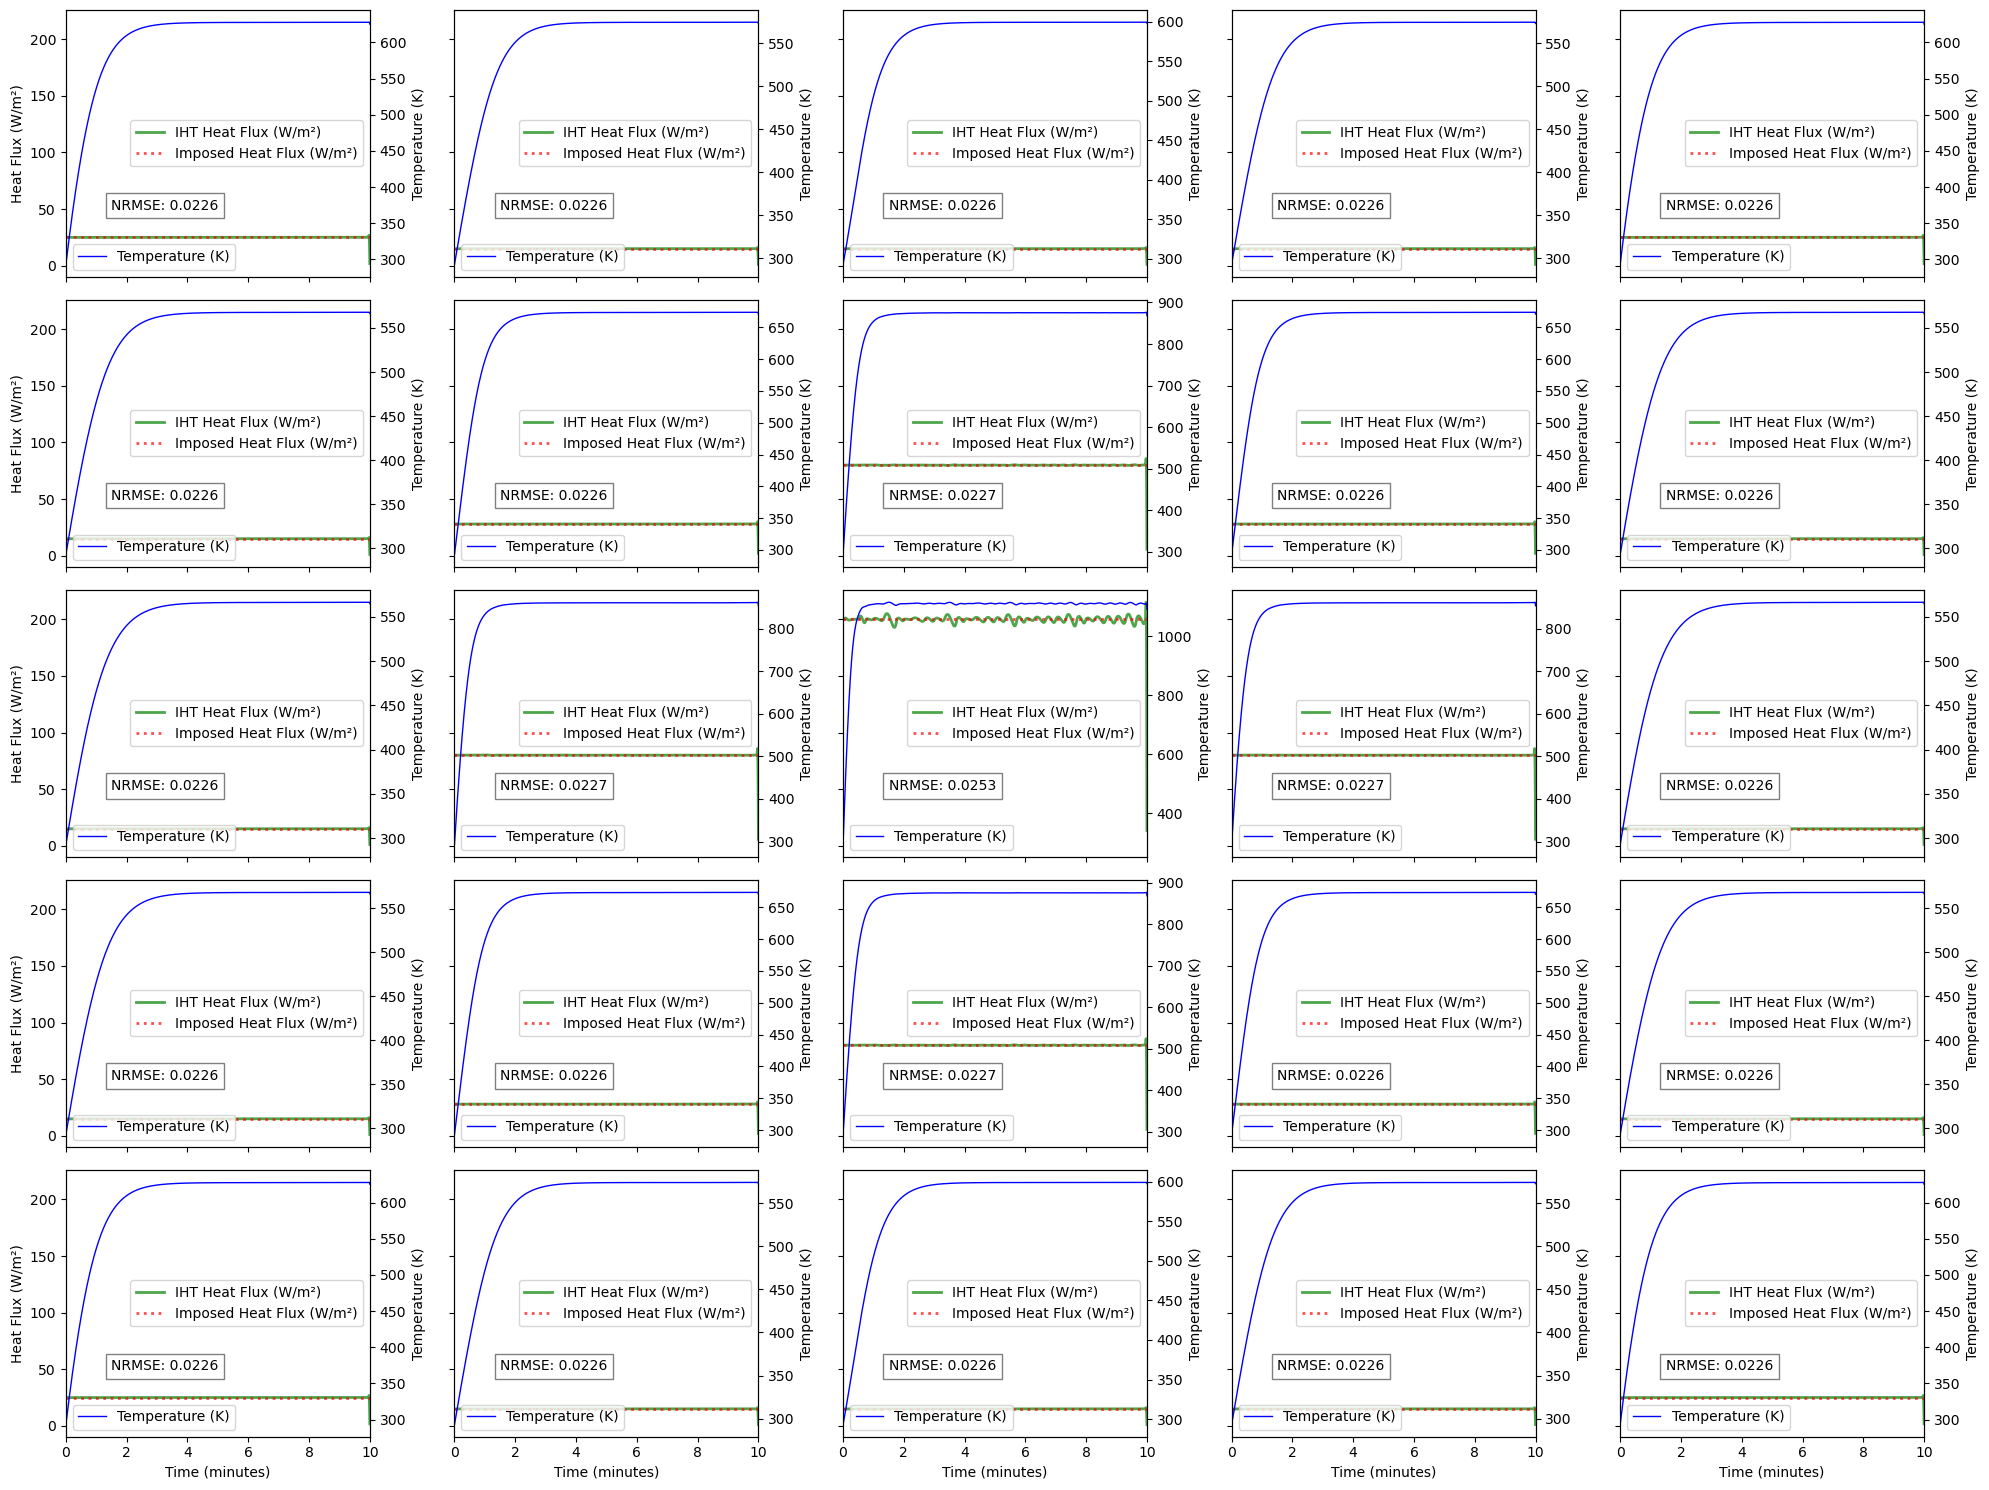

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
# Constants
stefan_boltzmann_constant = 5.67e-8
initial_temperature = 293 # make sure it is in kelvins
k_steel = 45  # Thermal conductivity of steel in W/mK

# User-defined variables
emission_time = 10 * 60  # 10 minutes
wall_thickness = 0.001
element_width = 0.05
element_height = 0.10
emissivity = 0.94
steel_density = 8050 
cp_steel = 490
convective_hfc_exposed = 10
convective_hfc_unexposed = 8
# Initializing grid heat flux for the forward model
grid_size = 5  # 3x3 grid --> the simplest 2D case possible
# heat_flux_grid = np.full((grid_size, grid_size), surrounding_heat_flux)
heat_flux_grid_2d = np.array([
    [25000, 15000, 15000, 15000, 25000],
    [15000, 28000, 80000, 28000, 15000],
    [15000, 80000, 200000, 80000, 15000],
    [15000, 28000, 80000, 28000, 15000],
    [25000, 15000, 15000, 15000, 25000]
])

# Energy balance for the 2D grid
def energy_balance_2d(t, T_flat):
    T = T_flat.reshape((grid_size, grid_size))
    dTdt = np.zeros_like(T)
    for i in range(grid_size):
        for j in range(grid_size):
            # Conduction in 2D
            q_cond = 0
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    edge_length = element_height if di != 0 else element_width
                    path_length = element_height if di == 0 else element_width
                    q_cond += k_steel * (T[ni, nj] - T[i, j]) * edge_length * wall_thickness / path_length

            # Heat flux contribution
            area = element_width * element_height
            q_in = heat_flux_grid_2d[i, j] * area if t < emission_time else 0
            q_conv_exp = convective_hfc_exposed * area * (T[i, j] - initial_temperature)
            q_conv_unexp = convective_hfc_unexposed * area * (T[i, j] - initial_temperature)
            q_rad = 2 * emissivity * stefan_boltzmann_constant * area * (T[i, j]**4 - 0.5*initial_temperature**4)

            # Energy balance
            dTdt[i, j] = (emissivity * q_in - q_conv_exp - q_conv_unexp - q_rad + q_cond) / (area * cp_steel * steel_density * wall_thickness)

    return dTdt.ravel()

# Initial condition for the 2D grid
T0_flat = np.full(grid_size**2, initial_temperature)

# Time duration
t_span = (0, emission_time)

# Generate time steps
t_eval = np.linspace(t_span[0], t_span[1], 6000)

# Solve the 2D differential equation with specified time steps
solution = solve_ivp(energy_balance_2d, t_span, T0_flat, method='RK45', t_eval=t_eval, dense_output=True)
num_time_steps = len(solution.t)
T_values_2d = solution.y.reshape((grid_size, grid_size, num_time_steps))

# Inverse Heat Transfer Model Function
def inverse_heat_transfer(T_values_2d, solution):
    num_time_steps = T_values_2d.shape[2]
    estimated_flux = np.zeros((grid_size, grid_size, num_time_steps))
    temp_grad = np.gradient(T_values_2d, axis=2) / np.gradient(solution.t)
    area = element_height * element_width

    for time_step in range(num_time_steps):
        for i in range(grid_size):
            for j in range(grid_size):
                grad_T = np.zeros(2)
                if i > 0:
                    grad_T[0] += k_steel * (-T_values_2d[i, j, time_step] + T_values_2d[i-1, j, time_step]) * element_height / element_width
                if i < grid_size - 1:
                    grad_T[0] += k_steel * (T_values_2d[i+1, j, time_step] - T_values_2d[i, j, time_step]) * element_height / element_width
                if j > 0:
                    grad_T[1] += k_steel * (-T_values_2d[i, j, time_step] + T_values_2d[i, j-1, time_step]) * element_width / element_height
                if j < grid_size - 1:
                    grad_T[1] += k_steel * (T_values_2d[i, j+1, time_step] - T_values_2d[i, j, time_step]) * element_width / element_height

                # Calculate heat flux
                q_cond = np.sum(grad_T) * wall_thickness
                q_conv = (convective_hfc_exposed + convective_hfc_unexposed) * area * (T_values_2d[i, j, time_step] - initial_temperature)
                q_rad = 2 * emissivity * stefan_boltzmann_constant * area * (T_values_2d[i, j, time_step]**4 - 0.5*initial_temperature**4)
                q_storage = cp_steel * steel_density * area * wall_thickness * temp_grad[i, j, time_step]

                # Calculate the estimated incident heat flux
                estimated_flux[i, j, time_step] = (q_storage + q_conv + q_rad - q_cond) / (area * emissivity)

    return estimated_flux

estimated_heat_flux = inverse_heat_transfer(T_values_2d, solution)

# Function to calculate RMSE and NRMSE
def calculate_rmse_nrmse(true_values, estimated_values):
    true_values_array = np.full_like(estimated_values, true_values)
    rmse = np.sqrt(mean_squared_error(true_values_array, estimated_values))
    nrmse = rmse / np.mean(true_values_array)
    return rmse, nrmse

# Function to calculate R-squared
def calculate_r_squared(true_values, estimated_values):
    true_values_array = np.full_like(estimated_values, true_values)
    return r2_score(true_values_array, estimated_values)

fig, axes = plt.subplots(nrows= T_values_2d.shape[1], ncols= T_values_2d.shape[0], figsize=(20, 15) , sharex = True, sharey = True)
axes = axes.ravel()

for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        
        # RMSE and NRMSE
        rmse, nrmse = calculate_rmse_nrmse(heat_flux_grid_2d[i, j], estimated_heat_flux[i, j, :])
        # r_squared = calculate_r_squared(heat_flux_grid_2d[i, j], estimated_heat_flux[i, j, :])
        
        ax = axes[idx]
        sns.lineplot(x = solution.t / 60, y = estimated_heat_flux[i, j, :]/1000,  label='IHT Heat Flux (W/m²)', c='green' , linewidth = 2, alpha = 0.7, ax = ax)
        ax.axhline(heat_flux_grid_2d[i, j]/1000, label='Imposed Heat Flux (W/m²)', color='red', linestyle='dotted', linewidth = 2 , alpha = 0.7)
        
        # Create a secondary y-axis for heat flux
        ax2 = ax.twinx()
        sns.lineplot(x = solution.t / 60, y = T_values_2d[i, j, :], label='Temperature (K)',  c='blue', ax = ax2 , linewidth = 1)

        
        ax.set_xlabel('Time (minutes)')
        ax2.set_ylabel('Temperature (K)')
        ax.legend(loc='lower left')
        
        ax.set_ylabel('Heat Flux (W/m²)')
        ax.legend(loc='center right')
        ax.set_xlim(0,solution.t[-1] / 60)
        ax.text(0.15, 0.25, f'NRMSE: {nrmse:.4f}', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

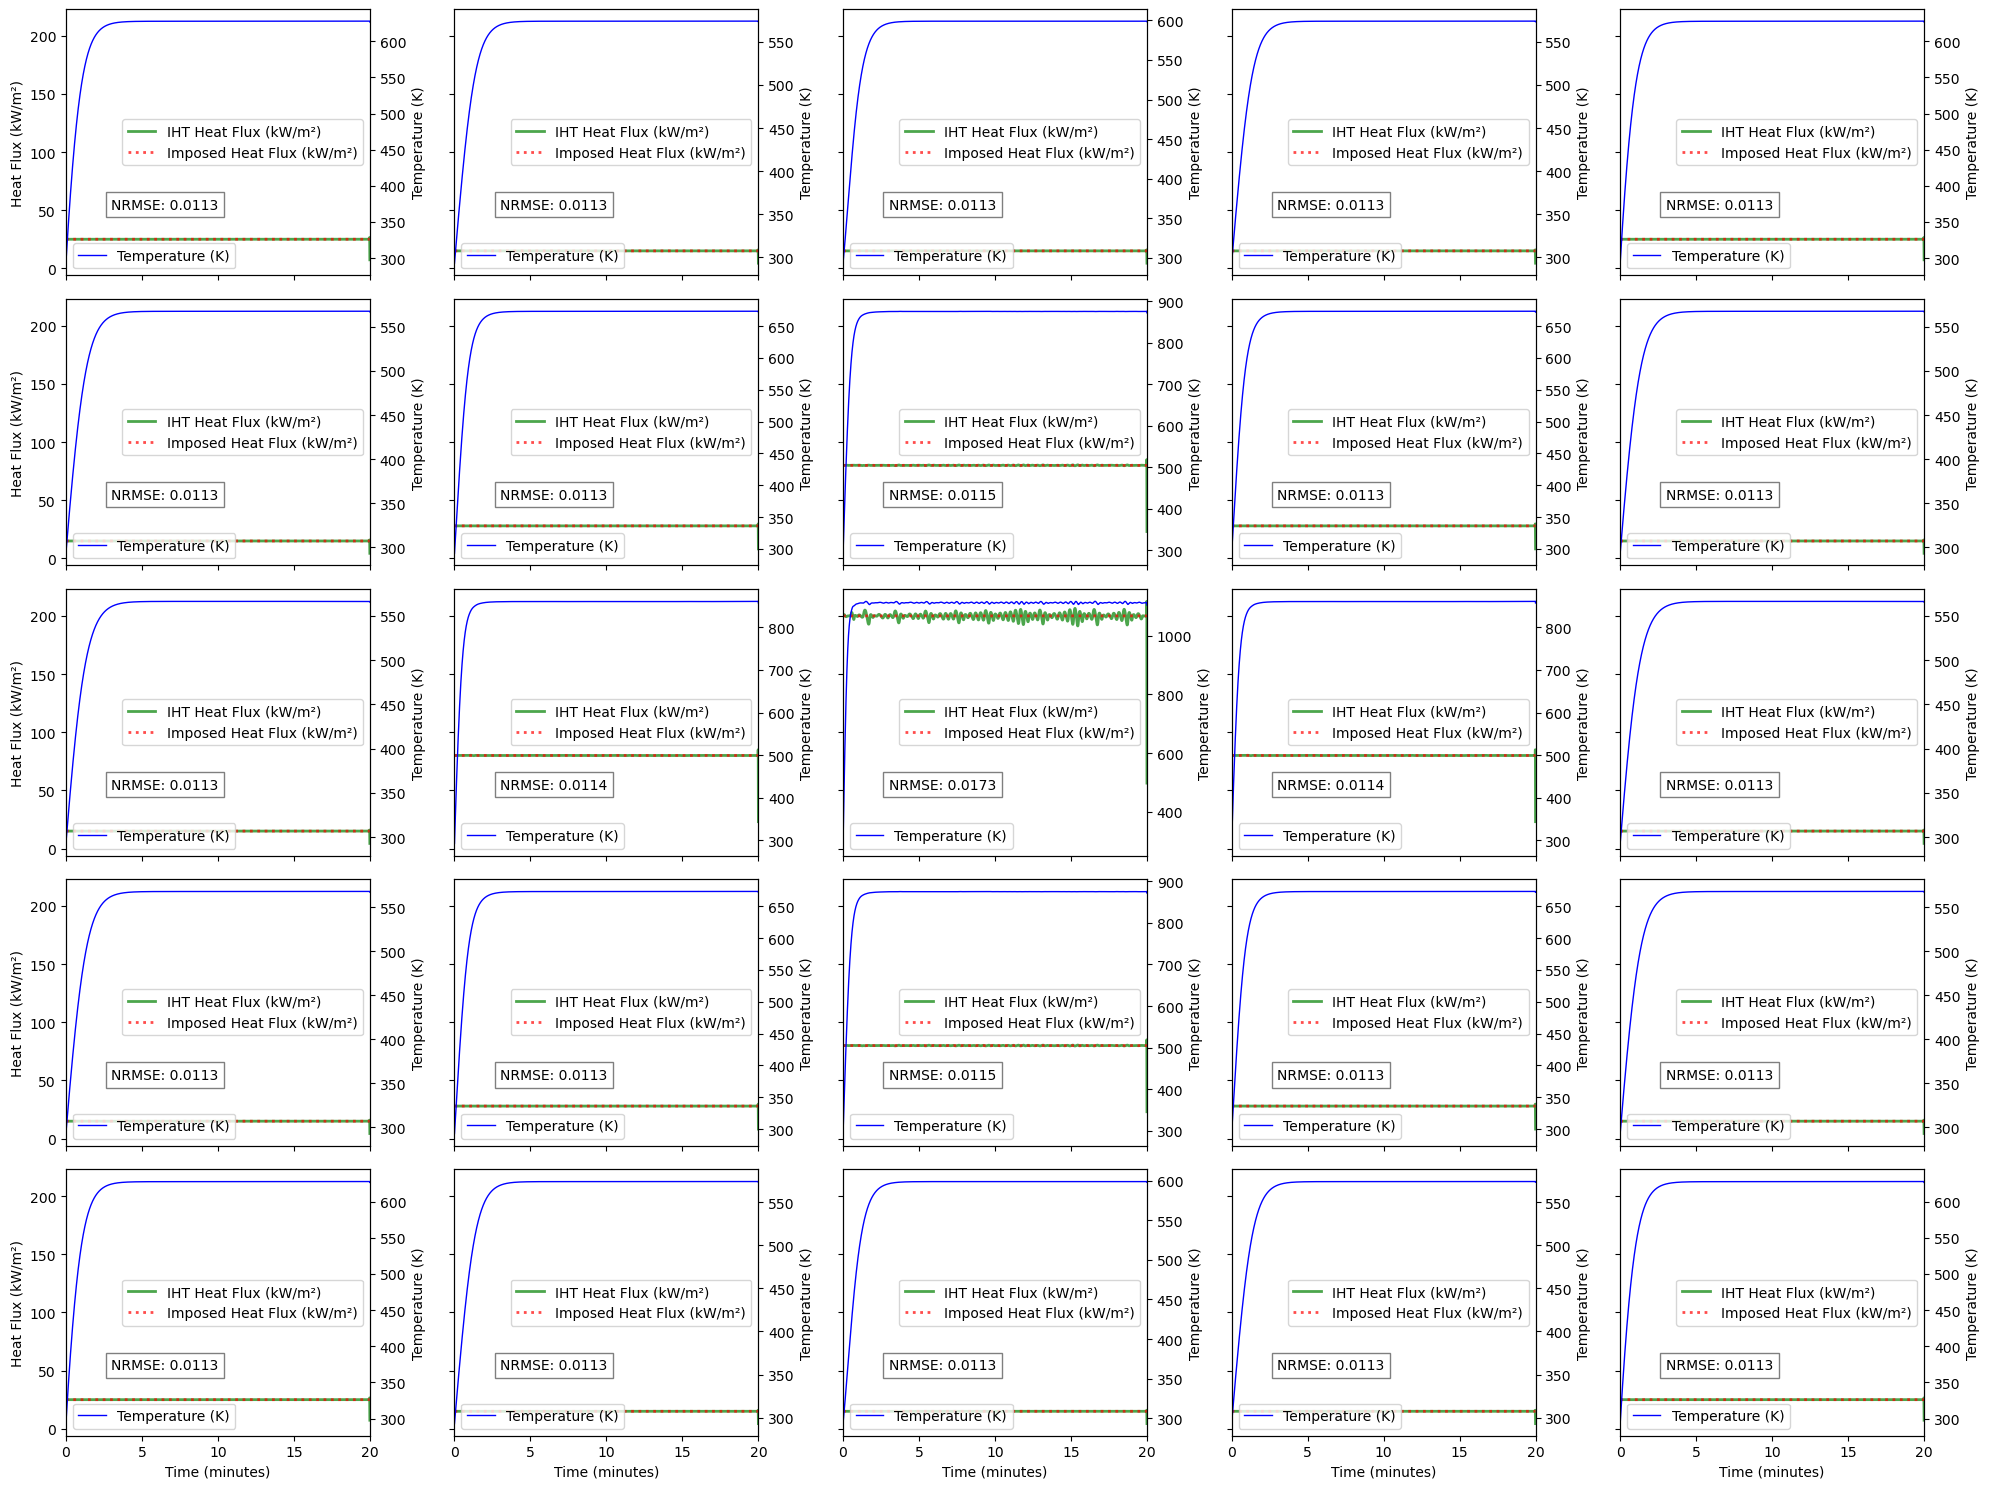

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Constants
stefan_boltzmann_constant = 5.67e-8
initial_temperature = 293  # make sure it is in kelvins
k_steel = 45  # Thermal conductivity of steel in W/mK

# User-defined variables
emission_time = 20 * 60  # 20 minutes in seconds
wall_thickness = 0.001
element_width = 0.05
element_height = 0.10
emissivity = 0.94
steel_density = 8050 
cp_steel = 490
convective_hfc_exposed = 10
convective_hfc_unexposed = 8

# Grid size 5x5
grid_size = 5

# Initializing 2D heat flux grid
heat_flux_grid_2d = np.array([
    [25000, 15000, 15000, 15000, 25000],
    [15000, 28000, 80000, 28000, 15000],
    [15000, 80000, 200000, 80000, 15000],
    [15000, 28000, 80000, 28000, 15000],
    [25000, 15000, 15000, 15000, 25000]
])

# Generate time steps
t_eval = np.linspace(0, emission_time, 6000)

# Create a 3D heat flux grid with time as the third dimension
# The heat flux is constant in this step, but it has been extended over time steps
heat_flux_grid = np.zeros((grid_size, grid_size, len(t_eval)))

# Populate the 3D grid for all time steps with the same 2D grid values (for now)
for t_idx in range(len(t_eval)):
    heat_flux_grid[:, :, t_idx] = heat_flux_grid_2d  # Can be modified for time-varying heat flux

# Energy balance for the 2D grid
def energy_balance_2d(t, T_flat):
    T = T_flat.reshape((grid_size, grid_size))
    dTdt = np.zeros_like(T)
    time_idx = np.searchsorted(t_eval, t)  # Get the time index closest to 't'
    
    for i in range(grid_size):
        for j in range(grid_size):
            # Conduction in 2D
            q_cond = 0
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    edge_length = element_height if di != 0 else element_width
                    path_length = element_height if di == 0 else element_width
                    q_cond += k_steel * (T[ni, nj] - T[i, j]) * edge_length * wall_thickness / path_length

            # Heat flux contribution
            area = element_width * element_height
            q_in = heat_flux_grid[i, j, time_idx] * area if t < emission_time else 0  # Time-varying heat flux
            q_conv_exp = convective_hfc_exposed * area * (T[i, j] - initial_temperature)
            q_conv_unexp = convective_hfc_unexposed * area * (T[i, j] - initial_temperature)
            q_rad = 2 * emissivity * stefan_boltzmann_constant * area * (T[i, j]**4 - 0.5*initial_temperature**4)

            # Energy balance
            dTdt[i, j] = (emissivity * q_in - q_conv_exp - q_conv_unexp - q_rad + q_cond) / (area * cp_steel * steel_density * wall_thickness)

    return dTdt.ravel()

# Initial condition for the 2D grid
T0_flat = np.full(grid_size**2, initial_temperature)

# Solve the 2D differential equation with specified time steps
solution = solve_ivp(energy_balance_2d, (0, emission_time), T0_flat, method='RK45', t_eval=t_eval, dense_output=True)

num_time_steps = len(solution.t)
T_values_2d = solution.y.reshape((grid_size, grid_size, num_time_steps))

# Inverse Heat Transfer Model Function
def inverse_heat_transfer(T_values_2d, solution):
    num_time_steps = T_values_2d.shape[2]
    estimated_flux = np.zeros((grid_size, grid_size, num_time_steps))
    temp_grad = np.gradient(T_values_2d, axis=2) / np.gradient(solution.t)
    area = element_height * element_width

    for time_step in range(num_time_steps):
        for i in range(grid_size):
            for j in range(grid_size):
                grad_T = np.zeros(2)
                if i > 0:
                    grad_T[0] += k_steel * (-T_values_2d[i, j, time_step] + T_values_2d[i-1, j, time_step]) * element_height / element_width
                if i < grid_size - 1:
                    grad_T[0] += k_steel * (T_values_2d[i+1, j, time_step] - T_values_2d[i, j, time_step]) * element_height / element_width
                if j > 0:
                    grad_T[1] += k_steel * (-T_values_2d[i, j, time_step] + T_values_2d[i, j-1, time_step]) * element_width / element_height
                if j < grid_size - 1:
                    grad_T[1] += k_steel * (T_values_2d[i, j+1, time_step] - T_values_2d[i, j, time_step]) * element_width / element_height

                # Calculate heat flux
                q_cond = np.sum(grad_T) * wall_thickness
                q_conv = (convective_hfc_exposed + convective_hfc_unexposed) * area * (T_values_2d[i, j, time_step] - initial_temperature)
                q_rad = 2 * emissivity * stefan_boltzmann_constant * area * (T_values_2d[i, j, time_step]**4 - 0.5*initial_temperature**4)
                q_storage = cp_steel * steel_density * area * wall_thickness * temp_grad[i, j, time_step]

                # Calculate the estimated incident heat flux
                estimated_flux[i, j, time_step] = (q_storage + q_conv + q_rad - q_cond) / (area * emissivity)

    return estimated_flux

estimated_heat_flux = inverse_heat_transfer(T_values_2d, solution)

# Function to calculate RMSE and NRMSE
def calculate_rmse_nrmse(true_values, estimated_values):
    rmse = np.sqrt(mean_squared_error(true_values, estimated_values))
    nrmse = rmse / np.mean(true_values)
    return rmse, nrmse

# Function to calculate R-squared
def calculate_r_squared(true_values, estimated_values):
    return r2_score(true_values, estimated_values)

# Plotting the results
fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j

        # RMSE and NRMSE
        rmse, nrmse = calculate_rmse_nrmse(heat_flux_grid[i, j, :], estimated_heat_flux[i, j, :])
        r_squared = calculate_r_squared(heat_flux_grid[i, j, :], estimated_heat_flux[i, j, :])

        ax = axes[idx]
        sns.lineplot(x=solution.t / 60, y=estimated_heat_flux[i, j, :] / 1000, label='IHT Heat Flux (kW/m²)', c='green', linewidth=2, alpha=0.7, ax=ax)
        sns.lineplot(x=solution.t / 60, y=heat_flux_grid[i, j, :] / 1000, label='Imposed Heat Flux (kW/m²)', color='red', linestyle='dotted', linewidth=2, alpha=0.7, ax=ax)

        # Create a secondary y-axis for temperature
        ax2 = ax.twinx()
        sns.lineplot(x=solution.t / 60, y=T_values_2d[i, j, :], label='Temperature (K)', c='blue', linewidth=1, ax=ax2)

        ax.set_xlabel('Time (minutes)')
        ax2.set_ylabel('Temperature (K)')
        ax.legend(loc='lower left')

        ax.set_ylabel('Heat Flux (kW/m²)')
        ax.legend(loc='center right')
        ax.set_xlim(0, solution.t[-1] / 60)
        ax.text(0.15, 0.25, f'NRMSE: {nrmse:.4f}', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

/var/folders/_d/f0q47dyd7610gk9h93ntdrd80000gp/T/ipykernel_23101/1380722640.py:125: RuntimeWarning: divide by zero encountered in divide
  nrmse = np.mean(np.abs((estimated_values - true_values)/true_values))
/var/folders/_d/f0q47dyd7610gk9h93ntdrd80000gp/T/ipykernel_23101/1380722640.py:125: RuntimeWarning: divide by zero encountered in divide
  nrmse = np.mean(np.abs((estimated_values - true_values)/true_values))
/var/folders/_d/f0q47dyd7610gk9h93ntdrd80000gp/T/ipykernel_23101/1380722640.py:125: RuntimeWarning: divide by zero encountered in divide
  nrmse = np.mean(np.abs((estimated_values - true_values)/true_values))
/var/folders/_d/f0q47dyd7610gk9h93ntdrd80000gp/T/ipykernel_23101/1380722640.py:125: RuntimeWarning: divide by zero encountered in divide
  nrmse = np.mean(np.abs((estimated_values - true_values)/true_values))
/var/folders/_d/f0q47dyd7610gk9h93ntdrd80000gp/T/ipykernel_23101/1380722640.py:125: RuntimeWarning: divide by zero encountered in divide
  nrmse = np.mean(np.abs((e

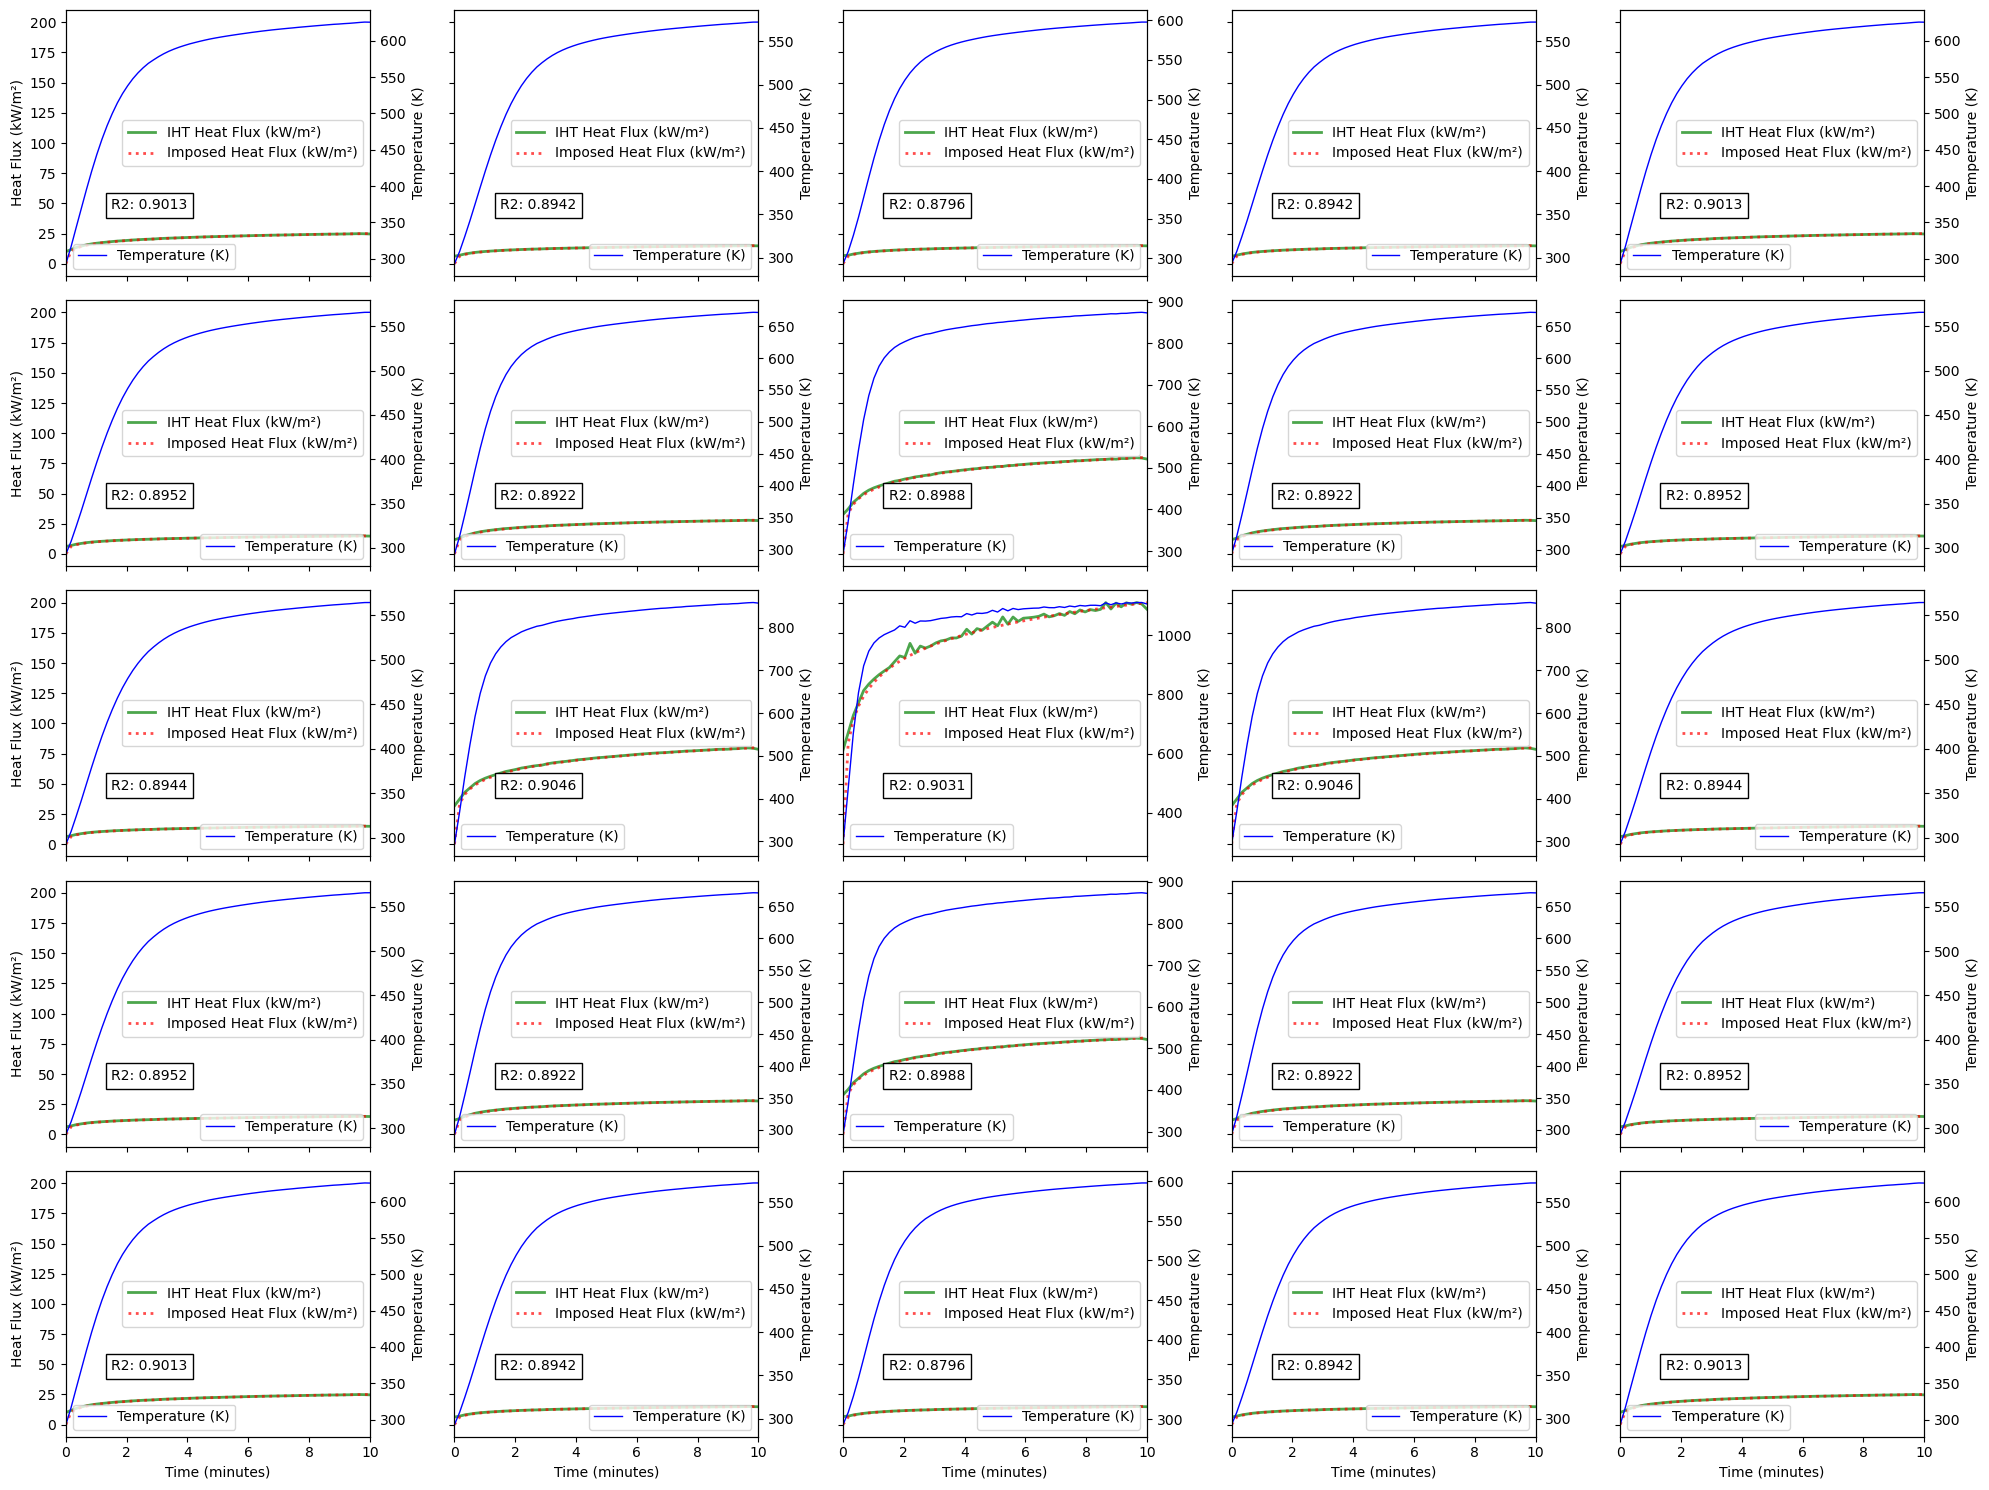

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Constants
stefan_boltzmann_constant = 5.67e-8
initial_temperature = 293  # make sure it is in kelvins
k_steel = 45  # Thermal conductivity of steel in W/mK

# User-defined variables
emission_time = 10 * 60  # 10 minutes
wall_thickness = 0.001
element_width = 0.05
element_height = 0.10
emissivity = 0.94
steel_density = 8050 
cp_steel = 490
convective_hfc_exposed = 10
convective_hfc_unexposed = 8

# Grid size 5x5
grid_size = 5

heat_flux_grid = np.array([
    [25000, 15000, 15000, 15000, 25000],
    [15000, 28000, 80000, 28000, 15000],
    [15000, 80000, 200000, 80000, 15000],
    [15000, 28000, 80000, 28000, 15000],
    [25000, 15000, 15000, 15000, 25000]
])

# Generate time steps
t_eval = np.linspace(0, emission_time, 6000)

# Variable for controlling the fraction of time for the rapid increase
increase_rate = 1000

# Create a logarithmic increase function for time based on the increase_rate
# By scaling the time by increase_rate, we compress the increase within the specified fraction of time
log_scaling = np.log(1 + (t_eval / np.max(t_eval)) * increase_rate) / np.log(1 + increase_rate)

# Create a 3D heat flux grid with time as the third dimension
heat_flux_grid = np.zeros((grid_size, grid_size, len(t_eval)))

# Populate the 3D grid with logarithmic time-varying values
for t_idx in range(len(t_eval)):
    heat_flux_grid[:, :, t_idx] = heat_flux_grid_2d * log_scaling[t_idx]

# Energy balance for the 2D grid
def energy_balance_2d(t, T_flat):
    T = T_flat.reshape((grid_size, grid_size))
    dTdt = np.zeros_like(T)
    time_idx = np.searchsorted(t_eval, t)  # Get the time index closest to 't'
    
    for i in range(grid_size):
        for j in range(grid_size):
            # Conduction in 2D
            q_cond = 0
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    edge_length = element_height if di != 0 else element_width
                    path_length = element_height if di == 0 else element_width
                    q_cond += k_steel * (T[ni, nj] - T[i, j]) * edge_length * wall_thickness / path_length

            # Heat flux contribution
            area = element_width * element_height
            q_in = heat_flux_grid[i, j, time_idx] * area if t < emission_time else 0
            q_conv_exp = convective_hfc_exposed * area * (T[i, j] - initial_temperature)
            q_conv_unexp = convective_hfc_unexposed * area * (T[i, j] - initial_temperature)
            q_rad = 2 * emissivity * stefan_boltzmann_constant * area * (T[i, j]**4 - 0.5*initial_temperature**4)

            # Energy balance
            dTdt[i, j] = (emissivity * q_in - q_conv_exp - q_conv_unexp - q_rad + q_cond) / (area * cp_steel * steel_density * wall_thickness)

    return dTdt.ravel()

# Initial condition for the 2D grid
T0_flat = np.full(grid_size**2, initial_temperature)

# Solve the 2D differential equation with specified time steps
solution = solve_ivp(energy_balance_2d, (0, emission_time), T0_flat, method='RK45', t_eval=t_eval, dense_output=True)

num_time_steps = len(solution.t)
T_values_2d = solution.y.reshape((grid_size, grid_size, num_time_steps))

# Inverse Heat Transfer Model Function
def inverse_heat_transfer(T_values_2d, solution):
    num_time_steps = T_values_2d.shape[2]
    estimated_flux = np.zeros((grid_size, grid_size, num_time_steps))
    temp_grad = np.gradient(T_values_2d, axis=2) / np.gradient(solution.t)
    area = element_height * element_width

    for time_step in range(num_time_steps):
        for i in range(grid_size):
            for j in range(grid_size):
                grad_T = np.zeros(2)
                if i > 0:
                    grad_T[0] += k_steel * (-T_values_2d[i, j, time_step] + T_values_2d[i-1, j, time_step]) * element_height / element_width
                if i < grid_size - 1:
                    grad_T[0] += k_steel * (T_values_2d[i+1, j, time_step] - T_values_2d[i, j, time_step]) * element_height / element_width
                if j > 0:
                    grad_T[1] += k_steel * (-T_values_2d[i, j, time_step] + T_values_2d[i, j-1, time_step]) * element_width / element_height
                if j < grid_size - 1:
                    grad_T[1] += k_steel * (T_values_2d[i, j+1, time_step] - T_values_2d[i, j, time_step]) * element_width / element_height

                # Calculate heat flux
                q_cond = np.sum(grad_T) * wall_thickness
                q_conv = (convective_hfc_exposed + convective_hfc_unexposed) * area * (T_values_2d[i, j, time_step] - initial_temperature)
                q_rad = 2 * emissivity * stefan_boltzmann_constant * area * (T_values_2d[i, j, time_step]**4 - 0.5*initial_temperature**4)
                q_storage = cp_steel * steel_density * area * wall_thickness * temp_grad[i, j, time_step]

                # Calculate the estimated incident heat flux
                estimated_flux[i, j, time_step] = (q_storage + q_conv + q_rad - q_cond) / (area * emissivity)

    return estimated_flux

estimated_heat_flux = inverse_heat_transfer(T_values_2d, solution)

# Function to calculate RMSE and NRMSE
def calculate_rmse_nrmse(true_values, estimated_values):
    rmse = np.sqrt(mean_squared_error(true_values, estimated_values))
    nrmse = np.mean(np.abs((estimated_values - true_values)/true_values))
    return rmse, nrmse

# Function to calculate R-squared
def calculate_r_squared(true_values, estimated_values):
    return r2_score(true_values, estimated_values)

# Plotting the results
fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j

        # RMSE and NRMSE
        rmse, nrmse = calculate_rmse_nrmse(heat_flux_grid[i, j, :], estimated_heat_flux[i, j, :])
        r_squared = calculate_r_squared(heat_flux_grid[i, j, :], estimated_heat_flux[i, j, :])

        ax = axes[idx]
        sns.lineplot(x=solution.t / 60, y=estimated_heat_flux[i, j, :] / 1000, label='IHT Heat Flux (kW/m²)', c='green', linewidth=2, alpha=0.7, ax=ax)
        sns.lineplot(x=solution.t / 60, y=heat_flux_grid[i, j, :] / 1000, label='Imposed Heat Flux (kW/m²)', color='red', linestyle='dotted', linewidth=2, alpha=0.7, ax=ax)

        # Create a secondary y-axis for temperature
        ax2 = ax.twinx()
        sns.lineplot(x=solution.t / 60, y=T_values_2d[i, j, :], label='Temperature (K)', c='blue', linewidth=1, ax=ax2)

        ax.set_xlabel('Time (minutes)')
        ax2.set_ylabel('Temperature (K)')
        ax.legend(loc='lower left')

        ax.set_ylabel('Heat Flux (kW/m²)')
        ax.legend(loc='center right')
        ax.set_xlim(0, solution.t[-1] / 60)
        # ax.text(0.15, 0.25, f'NRMSE: {nrmse:.4f}', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        ax.text(0.15, 0.25, f'R2: {r_squared:.4f}', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=1))


plt.tight_layout()
plt.show()